## Data Analysis

This notebook will be used to analyse data from Combination Lock experiments.


### Install Libraries


In [49]:
from statsmodels.stats.anova import AnovaRM
import pandas as pd
import matplotlib as mpl
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import glob
import json
from statistics import median, stdev

%pip install matplotlib
%pip install pandas statsmodels
%matplotlib inline


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Read in Files


In [50]:
log_dir = './docs/evaluation-logs/*'
filepaths = glob.glob(log_dir)

files = []

for path in filepaths:
    with open(path) as f:
        files.append(json.load(f)['data'])


### Extract Data Across Participants into Single Dict


In [51]:
fullDict = {}

for i in range(0, len(files)):

    for key in files[i]:
        for auth in files[i][key]:
            auth['participantNo'] = i

for f in files:
    fullDict = fullDict | f

print(len(fullDict))


108


### Traverse entire dataset, adding each list to the appropraite method list


In [52]:
methodsDict = {'tap6': [], 'tap10': [], 'direction6': [],
               'direction10': [], 'pin': [], 'pattern': []}

for key in fullDict.keys():
    method = fullDict[key][0]['method']
    numTicks = fullDict[key][0]['numTicks']

    if method == 'tap':
        if numTicks == '6':
            methodsDict['tap6'] += fullDict[key]
        else:
            methodsDict['tap10'] += fullDict[key]
    elif method == 'direction':
        if numTicks == '6':
            methodsDict['direction6'] += fullDict[key]
        else:
            methodsDict['direction10'] += fullDict[key]
    elif method == 'PATTERN':
        methodsDict['pattern'] += fullDict[key]
    elif method == 'PIN':
        methodsDict['pin'] += fullDict[key]

# Remove Abortions
for key in methodsDict:
    methodsDict[key] = list(
        filter(lambda x: x['endState'] != 'ABORTED', methodsDict[key]))


### Graph Average Error Rate For Each Method


{'tap6': 2.691105224025861, 'tap10': 6.142737811640878, 'direction6': 18.61163276716999, 'direction10': 11.799290794050975, 'pin': 3.95464299301212, 'pattern': 10.409629771373082}


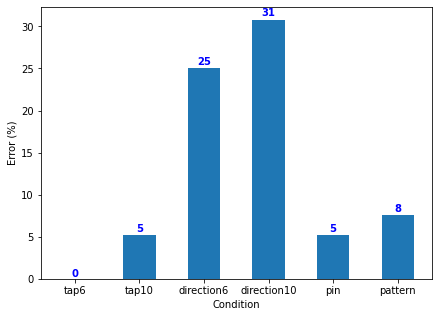

In [53]:
errorRates = []


def computeErrorRate(lst):
    errors = len(list(filter(lambda x: x['endState'] == 'FAILURE', lst)))
    return (errors / len(lst)) * 100


for i in range(0, len(files)):
    errorRates.append({})

for i in range(0, len(files)):
    for method in methodsDict:
        errorRates[i][method] = computeErrorRate(
            list(filter(lambda x: x['participantNo'] == i, methodsDict[method])))

# Get dict with lists with all error rates.
errs_aggregated = {}
for method in ['tap6', 'tap10', 'direction6', 'direction10', 'pin', 'pattern']:
    errs_aggregated[method] = []
    for dic in errorRates:
        errs_aggregated[method].append(dic[method])

# Create dicts that map to median and standard deviation.
errs_aggregated_med = errs_aggregated.copy()
errs_aggregated_dev = errs_aggregated.copy()
for key in errs_aggregated:
    errs_aggregated_med[key] = median(errs_aggregated[key])
    errs_aggregated_dev[key] = stdev(errs_aggregated[key])
print(errs_aggregated_dev)

x = list(errs_aggregated_med.keys())
y = list(errs_aggregated_med.values())

fig, ax = plt.subplots(figsize=(7, 5))
ax.set_ylabel('Error (%)')
ax.set_xlabel('Condition')

rects = ax.bar(x, y, 0.5)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' %
            round(height),  ha='center', va='bottom', color='blue', fontweight='bold')


#### Repeated Measures ANOVA on Error Rates

In [54]:
fileTable = []
for method in errs_aggregated:
    for index, value in enumerate(errs_aggregated[method]):
        fileTable.append([index, method, value])

df = pd.DataFrame(fileTable, columns = ['participant', 'method', 'errorRate'])
print(AnovaRM(df,'errorRate',subject='participant', within=['method']).fit())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 27.9922 5.0000 85.0000 0.0000



### Graph Average Authentication Time for Successful Sessions


{'tap6': 7209.5, 'tap10': 7026, 'direction6': 9123, 'direction10': 10731, 'pin': 1315, 'pattern': 1802}
{'tap6': 2416.6960590760928, 'tap10': 3194.011206086757, 'direction6': 3998.7315295771564, 'direction10': 4597.9556506372555, 'pin': 837.4006960618999, 'pattern': 1110.0238634136242}


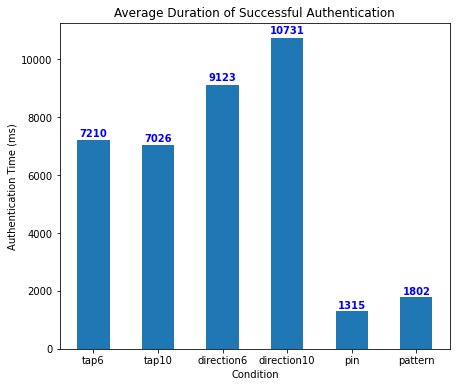

In [55]:
def computeAverageSuccessTime(lst):
    successfulAuths = list(filter(lambda x: x['endState'] == 'SUCCESS', lst))
    total = []
    for val in lst:
        total.append(val['elapsedTimeInMilliseconds'])
    return (median(total), stdev(total))

authTimes = {}
deviations = {}
for method in methodsDict:
    authTimes[method],deviations[method] = computeAverageSuccessTime(methodsDict[method])

print(authTimes)
print(deviations)

fig, ax = plt.subplots(figsize=(7, 6))
ax.set_ylabel('Authentication Time (ms)')
ax.set_xlabel('Condition')
ax.set_title('Average Duration of Successful Authentication')

x = list(authTimes.keys())
y = list(authTimes.values())
rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' %
            round(height),  ha='center', va='bottom', color='blue', fontweight='bold')


In [56]:
# def computeAverageSuccessTime(lst):
#     successfulAuths = list(filter(lambda x: x['endState'] == 'SUCCESS', lst))
#     total = []
#     for val in lst:
#         total.append(val['elapsedTimeInMilliseconds'])
#     return median(total)


# successRates = {}
# for method in methodsDict:
#     successRates[method] = computeAverageSuccessTime(methodsDict[method])

# fig, ax = plt.subplots(figsize=(7, 6))
# ax.set_ylabel('Authentication Time (ms)')
# ax.set_xlabel('Condition')
# ax.set_title('Average Duration of Successful Authentication')

# x = list(successRates.keys())
# y = list(successRates.values())
# rects = ax.bar(x, y, 0.5)

# for rect in rects:
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' %
#             round(height),  ha='center', va='bottom', color='blue', fontweight='bold')


### Time Distribution


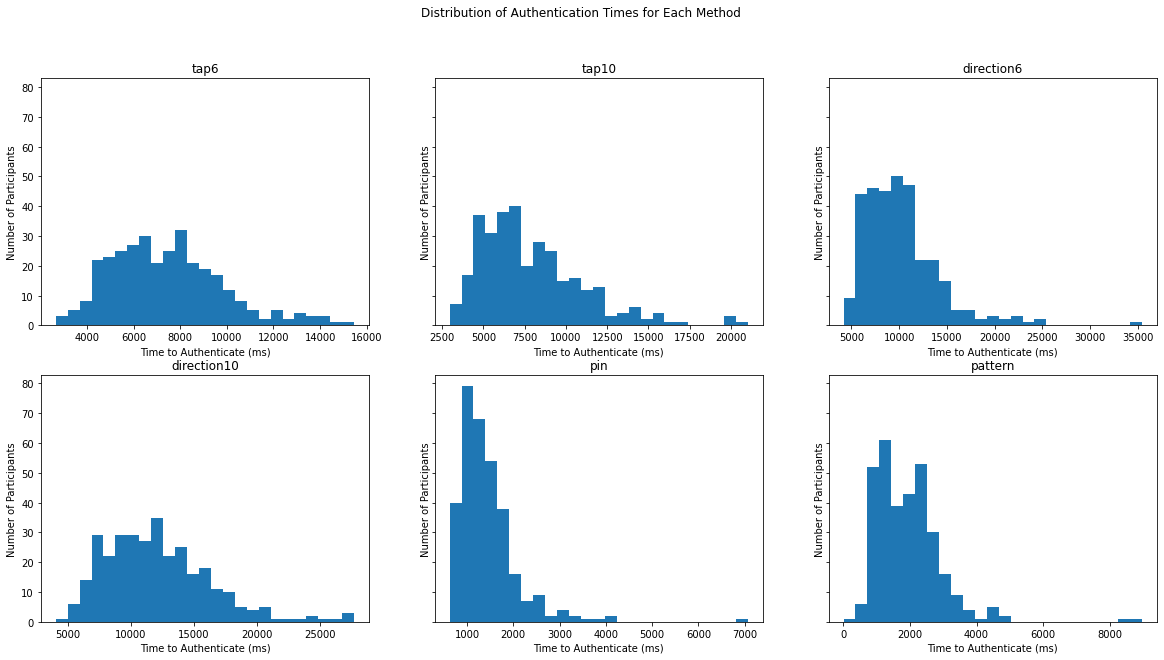

In [57]:
successfulAuths = methodsDict.copy()

for item in successfulAuths:
    successfulAuths[item] = list(
        filter(lambda x: x['endState'] == 'SUCCESS', successfulAuths[item]))
successfulAuthsTimeList = list(map(lambda x: {x: list(map(
    lambda y: y['elapsedTimeInMilliseconds'], successfulAuths[x]))}, successfulAuths))

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20, 10))
fig.suptitle('Distribution of Authentication Times for Each Method')

n_bins = 25


for i in range(0, 2):
    for j in range(0, 3):
        axs[i, j].hist(successfulAuthsTimeList[3*i+j].values(), bins=n_bins)
        axs[i, j].set_title(list(successfulAuthsTimeList[3*i+j].keys())[0])
        axs[i, j].set_xlabel('Time to Authenticate (ms)')
        axs[i, j].set_ylabel('Number of Participants')


### Statistical Tests - Repeated Measures One-Way ANOVA


In [58]:
# Parses files and puts data in a format for statistical tests
def getMethod(auth):
    if auth['method'] == 'tap':
        if auth['numTicks'] == '6':
            return 'tap6'
        else:
            return 'tap10'
    elif auth['method'] == 'direction':
        if auth['numTicks'] == '6':
            return 'direction6'
        else:
            return 'direction10'
    elif auth['method'] == 'PATTERN':
        return 'pattern'
    elif auth['method'] == 'PIN':
        return 'PIN'


def fileToTable(i, f, end=None):
    totalRows = []
    for key in f:
        for auth in f[key]:
            if auth['endState'] != 'ABORTED':
                if end == None:
                    totalRows.append(
                        [i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState'], 'null'])
                elif auth['endState'] == end:
                    totalRows.append(
                        [i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState'], 'null'])
    return totalRows


def createFileTable(end=None):
    fileTable = [['participant', 'method',
                  'elapsedTimeInMilliseconds', 'endState', 'errors']]
    for index, file in enumerate(files):
        fileTable += fileToTable(index, file, end)
    return fileTable


totalFileTable = createFileTable()
successFileTable = createFileTable(end='SUCCESS')
failureFileTable = createFileTable(end='FAILURE')


def createTempFileFromTable(fileName, table):
    with open(fileName, 'w') as f:
        for line in table:
            f.write(','.join([str(line[0]), line[1], str(
                line[2]), str(line[3]), str(line[4]), '\n']))

createTempFileFromTable('successTemp.csv', successFileTable)

df = pd.read_csv('successTemp.csv')
print('REPEATED MEASURES ANOVA ON AUTHENTICATION TIME:\n')
print(AnovaRM(df, 'elapsedTimeInMilliseconds', 'participant',
      within=['method'], aggregate_func=median).fit())

REPEATED MEASURES ANOVA ON AUTHENTICATION TIME:

                Anova
       F Value  Num DF  Den DF Pr > F
-------------------------------------
method 140.5877 5.0000 85.0000 0.0000



# User Perception


PIN = 0.2581988897471611, Pattern = 0.4140393356054125, Combination - Tap - 6 = 0.7367883976130073, Combination - Tap - 10 = 1.0555973258234952, Combination - Direction - 6 = 1.3870146083619754, Combination - Direction - 10 = 1.3020130933435712, 
PIN = 1.245945806357946, Pattern = 1.0600988273786194, Combination - Tap - 6 = 0.9856107606091623, Combination - Tap - 10 = 1.2649110640673518, Combination - Direction - 6 = 1.5796322658258457, Combination - Direction - 10 = 1.6761634196950517, 
PIN = 0.45773770821706344, Pattern = 0.828078671210825, Combination - Tap - 6 = 1.1832159566199232, Combination - Tap - 10 = 1.486446705914413, Combination - Direction - 6 = 1.6676187756655838, Combination - Direction - 10 = 1.4540583599999397, 
PIN = 0.8837151016885368, Pattern = 1.5522640914238175, Combination - Tap - 6 = 1.88477610139267, Combination - Tap - 10 = 2.051712409068047, Combination - Direction - 6 = 1.6818357317441643, Combination - Direction - 10 = 1.8439088914585775, 
PIN = 1.334523278

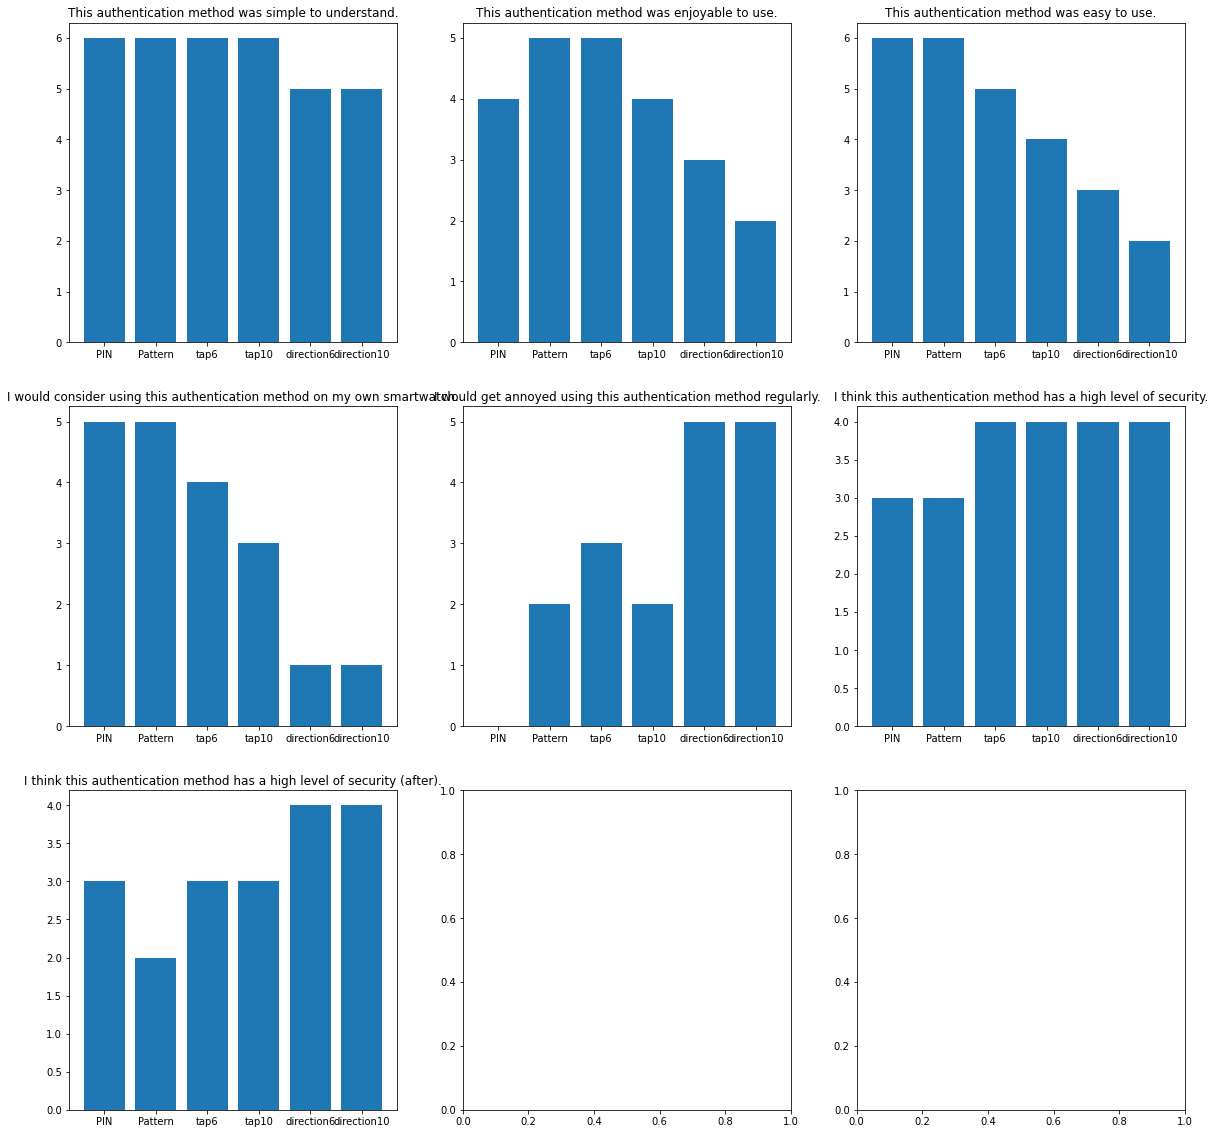

In [59]:

perception_dict = [{'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]}, 
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]}]

with open('docs/user_perception.csv') as f:
    f.readline()
    for line in f:
        line = line.split(',')[1:]
        perception_dict[0][line[0]].append(int(line[1]))
        perception_dict[1][line[0]].append(int(line[2]))
        perception_dict[2][line[0]].append(int(line[3]))
        perception_dict[3][line[0]].append(int(line[4]))
        perception_dict[4][line[0]].append(int(line[5]))
        perception_dict[5][line[0]].append(int(line[6]))
        perception_dict[6][line[0]].append(int(line[8]))

def get_std_deviations(method, axis):
    valueList = []
    with open('docs/user_perception.csv') as f:
        for line in f:
            line = line.split(',')[1:]
            if line[0] == method:
                valueList.append(int(line[axis]))
    return stdev(valueList)



for dic in perception_dict:
    for key in dic:
        dic[key] = median(dic[key])
    
    dic['tap6'] = dic.pop('Combination - Tap - 6')
    dic['tap10'] = dic.pop('Combination - Tap - 10')
    dic['direction6'] = dic.pop('Combination - Direction - 6')
    dic['direction10'] = dic.pop('Combination - Direction - 10')


fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs[0, 0].set_title('This authentication method was simple to understand.')
axs[0, 0].bar(list(perception_dict[0].keys()),
              list(perception_dict[0].values()))
axs[0, 1].set_title('This authentication method was enjoyable to use.')
axs[0, 1].bar(list(perception_dict[1].keys()),
              list(perception_dict[1].values()))
axs[0, 2].set_title('This authentication method was easy to use.')
axs[0, 2].bar(list(perception_dict[2].keys()),
              list(perception_dict[2].values()))
axs[1, 0].set_title(
    'I would consider using this authentication method on my own smartwatch.')
axs[1, 0].bar(list(perception_dict[3].keys()),
              list(perception_dict[3].values()))
axs[1, 1].set_title(
    'I would get annoyed using this authentication method regularly.')
axs[1, 1].bar(list(perception_dict[4].keys()),
              list(perception_dict[4].values()))
axs[1, 2].set_title('I think this authentication method has a high level of security.')
axs[1, 2].bar(list(perception_dict[5].keys()),
              list(perception_dict[5].values()))
axs[2, 0].set_title(
    'I think this authentication method has a high level of security (after).')
axs[2, 0].bar(list(perception_dict[6].keys()),
              list(perception_dict[6].values()))

methods = ['PIN','Pattern', 'Combination - Tap - 6', 'Combination - Tap - 10', 'Combination - Direction - 6', 'Combination - Direction - 10']
for i in range(1,9):
    if i==7:
        continue;
    for method in methods:
        print(method +' =', end=' ')
        print(get_std_deviations(method, axis=i), end=', ')
    print('\n ====================================================' * 3)

In [60]:
df = pd.read_csv('docs/user_perception.csv')
print('THIS AUTHENTICATION METHOD WAS SIMPLE TO UNDERSTAND:\n')
print(AnovaRM(df, 'This authentication method was simple to understand.',
      subject='ParticipantNumber', within=['method'], aggregate_func=median).fit())
print('THIS AUTHENTICATION METHOD WAS ENJOYABLE TO USE:\n')
print(AnovaRM(df, 'This authentication method was enjoyable to use.',
      subject='ParticipantNumber', within=['method'], aggregate_func=median).fit())
print('THIS AUTHENTICATION METHOD WAS EASY TO USE:\n')
print(AnovaRM(df, 'This authentication method was easy to use.',
      subject='ParticipantNumber', within=['method'], aggregate_func=median).fit())
print('I WOULD CONSIDER USING THIS AUTHENTICATION METHOD ON MY OWN SMARTWATCH:\n')
print(AnovaRM(df, 'I would consider using this authentication method on my own smartwatch.',
      subject='ParticipantNumber', within=['method'], aggregate_func=median).fit())
print('I WOULD GET ANNOYED USING THIS AUTHENTICATION METHOD REGULARLY:\n')
print(AnovaRM(df, 'I would get annoyed using this authentication method regularly.',
      subject='ParticipantNumber', within=['method'], aggregate_func=median).fit())
print('I THINK THIS AUTHENTICATION METHOD HAS A HIGH LEVEL OF SECURITY:\n')
print(AnovaRM(df, 'I think this authentication method has a high level of security.',
      subject='ParticipantNumber', within=['method'], aggregate_func=median).fit())
print('I THINK THIS AUTHENTICATION METHOD HAS A HIGH LEVEL OF SECURITY(AFTER):\n')
a = AnovaRM(df, 'I think this authentication method has a high level of security (after).',
      'ParticipantNumber', within=['method'], aggregate_func=median).fit()
print(a)

THIS AUTHENTICATION METHOD WAS SIMPLE TO UNDERSTAND:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  6.0110 5.0000 70.0000 0.0001

THIS AUTHENTICATION METHOD WAS ENJOYABLE TO USE:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  9.3526 5.0000 70.0000 0.0000

THIS AUTHENTICATION METHOD WAS EASY TO USE:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 24.2368 5.0000 70.0000 0.0000

I WOULD CONSIDER USING THIS AUTHENTICATION METHOD ON MY OWN SMARTWATCH:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 16.5365 5.0000 70.0000 0.0000

I WOULD GET ANNOYED USING THIS AUTHENTICATION METHOD REGULARLY:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 15.8820 5.0000 70.0000 0.0000

I THINK THIS AUTHENTICATION METHOD HAS A HIGH LE